In [25]:
import sys
import os
from dotenv import load_dotenv
import warnings

# Configurar el Path del Proyecto (para neuro_agent)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
neuro_agent_dir = os.path.join(project_root, 'src')
if neuro_agent_dir not in sys.path:
    sys.path.append(neuro_agent_dir)

# Cargar Variables de Entorno
load_dotenv(os.path.join(project_root, ".env"), override=True)

# Habilitar recarga automática
%load_ext autoreload
%autoreload 2

# Silenciar warnings específicos de LangSmith
warnings.filterwarnings("ignore", message="LangSmith now uses UUID v7")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="LangSmith now uses UUID v7", 
    category=UserWarning,
)

# Deep Agent for Research

## Overview 

<img src="./assets/agent_header.png" width="800" style="display:block; margin-left:0;">

Now, we can put everything we have learned together:

* We will use **TODOs** to keep track of tasks. 
* We will use **files** to store raw tool call results. 
* We will **delegate research tasks to sub-agents** for context isolation. 

## Search Tool 

We'll build a search tool that offloads raw contents to files and returns only a summary to the agent. This is a common pattern for long-running agent trajectories, [as we've seen with Manus](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus)! 

### Core Components

1. **Search Execution (`run_tavily_search`)**: Performs the actual web search using Tavily API with configurable parameters for results count and topic filtering.

2. **Content Summarization (`summarize_webpage_content`)**: Uses a lightweight model (GPT-4o-mini) to generate structured summaries of webpage content, producing both a descriptive filename and key learnings summary.

3. **Result Processing (`process_search_results`)**: Fetches full webpage content via HTTP, converts HTML to markdown using `markdownify`, and generates summaries for each result.

4. **Context Offloading (`tavily_search` tool)**: The main tool that:
   - Executes search and processes results
   - Saves full content to files in agent state (context offloading)
   - Returns only minimal summaries to the agent (prevents context spam)
   - Uses LangGraph `Command` to update both files and messages

5. **Strategic Thinking (`think_tool`)**: Provides a structured reflection mechanism for agents to analyze findings, assess gaps, and plan next steps in their research workflow.

This architecture solves the token efficiency problem by storing detailed search results in files while keeping the agent's working context minimal and focused.

<div style="background-color: #fff3b0; padding: 10px; border-radius: 4px;">
<b>Note:</b>  
The <code>create_react_agent</code> was moved from the LangGraph library to the LangChain library and renamed to <code>create_agent</code> in the 1.0 code release post-filming. There are slight changes to the imports and code to accommodate this. The video may display the previous configuration.
</div>

In [27]:
%%writefile ../src/neuro_agent/infrastructure/tools/research.py
"""Research Tools."""
import os
from datetime import datetime
import uuid, base64
import httpx
import urllib3
import ssl
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.tools import tool
from langchain_core.tools import InjectedToolArg, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from markdownify import markdownify
from pydantic import BaseModel, Field
from tavily import TavilyClient
from typing import Annotated, Literal, Optional, Any
from langchain_aws import ChatBedrockConverse

# Global SSL Resilience
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
try:
    ssl._create_default_https_context = ssl._create_unverified_context
except Exception:
    pass

summarization_model = ChatBedrockConverse(model="us.amazon.nova-pro-v1:0", region_name="us-east-1", temperature=0.0)
from deep_agents_from_scratch.prompts import SUMMARIZE_WEB_SEARCH
from neuro_agent.domain.state import AgentState
DeepAgentState = AgentState

tavily_client = TavilyClient()
HTTPX_CLIENT = httpx.Client(timeout=30.0, verify=False)

class Summary(BaseModel):
    filename: str = Field(description="Name of the file to store.")
    summary: str = Field(description="Key learnings from the webpage.")

def get_today_str() -> str:
    return datetime.now().strftime("%a %b %-d, %Y")

def run_tavily_search(search_query: str, max_results: int = 1, topic="general", include_raw_content=True) -> dict:
    try:
        return tavily_client.search(search_query, max_results=max_results, include_raw_content=include_raw_content, topic=topic)
    except Exception as e:
        return {"results": [], "error": f"Tavily search failed: {e}"}

def summarize_webpage_content(webpage_content: str) -> Summary:
    try:
        structured_model = summarization_model.with_structured_output(Summary)
        return structured_model.invoke([HumanMessage(content=SUMMARIZE_WEB_SEARCH.format(webpage_content=webpage_content, date=get_today_str()))])
    except Exception:
        return Summary(filename="search_result.md", summary=webpage_content[:1000])

def process_search_results(results: dict) -> list[dict]:
    processed_results = []
    for result in results.get('results', []):
        url = result['url']
        try:
            response = HTTPX_CLIENT.get(url)
            if response.status_code == 200:
                raw_content = markdownify(response.text)
                summary_obj = summarize_webpage_content(raw_content)
            else:
                raw_content = result.get('raw_content', '')
                summary_obj = Summary(filename="URL_error.md", summary=result.get('content', 'Error reading URL.'))
        except Exception:
            raw_content = result.get('raw_content', '')
            summary_obj = Summary(filename="error.md", summary=result.get('content', 'Connection error.'))
        uid = base64.urlsafe_b64encode(uuid.uuid4().bytes).rstrip(b"=").decode("ascii")[:8]
        name, ext = os.path.splitext(summary_obj.filename)
        summary_obj.filename = f"{name}_{uid}{ext}"
        processed_results.append({'url': url, 'title': result['title'], 'summary': summary_obj.summary, 'filename': summary_obj.filename, 'raw_content': raw_content})
    return processed_results

@tool
def tavily_search(
    query: str, 
    state: Annotated[Optional[dict], InjectedState] = None, 
    tool_call_id: Annotated[Optional[str], InjectedToolCallId] = None, 
    max_results: Annotated[int, InjectedToolArg] = 1, 
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general"
) -> Command:
    """Search web and save results."""
    if state is None or tool_call_id is None:
        return Command(update={"messages": [ToolMessage("Error: Missing injected arguments", tool_call_id="")]})

    res = run_tavily_search(query, max_results=max_results, topic=topic)
    processed = process_search_results(res)
    files = state.get("files", {})
    summaries = []
    for r in processed:
        fn = r['filename']
        files[fn] = f"# {r['title']}\n\n{r['summary']}\n\n{r['raw_content']}"
        summaries.append(f"- {fn}: {r['summary']}...")
    return Command(update={"files": files, "messages": [ToolMessage("🔍 Results:\n" + "\n".join(summaries), tool_call_id=tool_call_id)]})

@tool
def think_tool(reflection: str) -> str:
    """Record a reflection or thought process."""
    return f"Reflection recorded: {reflection}"


Overwriting ../src/neuro_agent/infrastructure/tools/research.py


## Deep Agent

Now, we can just apply all of our prior learnings: 

* We'll give the researcher a `think_tool` and our `search_tool` above.
* We'll give our parent agent file tools, a `think_tool`, and a `task` tool. 

In [28]:
from datetime import datetime
from IPython.display import Image, display
from utils import show_prompt, stream_agent

# Imports de neuro_agent
from neuro_agent.domain.state import AgentState
from neuro_agent.infrastructure.tools.research import tavily_search, think_tool, get_today_str
from neuro_agent.infrastructure.tools.delegation import create_subagent_tool
from neuro_agent.infrastructure.tools.filesystem import ls, read_file, write_file
from neuro_agent.infrastructure.tools.planning import write_todos, read_todos

# Import de create_agent (actualizado 1.0)
from langchain.agents import create_agent

# Prompts (importados de deep_agents_from_scratch)
from deep_agents_from_scratch.prompts import (
    FILE_USAGE_INSTRUCTIONS, RESEARCHER_INSTRUCTIONS, SUBAGENT_USAGE_INSTRUCTIONS, TODO_USAGE_INSTRUCTIONS
)

from langchain_aws import ChatBedrockConverse
model = ChatBedrockConverse(model="us.amazon.nova-2-lite-v1:0", region_name="us-east-1", temperature=0.0)

max_concurrent_research_units = 3
max_researcher_iterations = 3

sub_agent_tools = [tavily_search, think_tool]
built_in_tools = [ls, read_file, write_file, write_todos, read_todos, think_tool]

# Configuración del Sub-Agente Researcher
researcher_config = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": RESEARCHER_INSTRUCTIONS.format(date=get_today_str()),
    "tools": ["tavily_search", "think_tool"]
}

# Herramienta de delegación usando el factory de neuro_agent
task_tool = create_subagent_tool(
    tools=sub_agent_tools,
    subagents=[researcher_config],
    llm=model,
    state_schema=AgentState
)

all_tools = list({t.name: t for t in sub_agent_tools + built_in_tools}.values()) + [task_tool]

SUBAGENT_INSTRUCTIONS = SUBAGENT_USAGE_INSTRUCTIONS.format(
    max_concurrent_research_units=max_concurrent_research_units,
    max_researcher_iterations=max_researcher_iterations,
    date=datetime.now().strftime("%a %b %-d, %Y")
)

INSTRUCTIONS = (
    "# TODO MANAGEMENT\n"
    + TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# FILE SYSTEM USAGE\n"
    + FILE_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# SUB-AGENT DELEGATION\n"
    + SUBAGENT_INSTRUCTIONS
)


In [29]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 1-2 search tool calls maximum                                                        │
│  - **Normal queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Very Complex queries**: Use up to 5 search tool calls maximum                                              │
│  - **Always stop**: After 5 search tool calls if you c

In [30]:
from neuro_agent.infrastructure.memory.dynamo_checkpointer import ChunkedDynamoDBSaver
INSTRUCTIONS = (
    "# TODO MANAGEMENT\n"
    + TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# FILE SYSTEM USAGE\n"
    + FILE_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# SUB-AGENT DELEGATION\n"
    + SUBAGENT_INSTRUCTIONS
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # TODO MANAGEMENT                                                                                              │
│  ⛔ MANDATORY EXECUTION CONTRACT — The TODO list is NOT optional.                                               │
│                                                                                                                 │
│  ## Rules (Non-Negotiable)                                                                                      │
│  1. ALWAYS create a TODO plan using write_todos as your FIRST action on ANY user request.                       │
│  2. EVERY step in the TODO MUST be executed using the appropriate tool — NO exceptions.                         │
│  3. NEVER answer from memory alone — you MUST use tools to complete each step.                                  │
│  4. After executing a step, mark it as completed using write_todos.                                             │
│  5. Use read_todos frequently to verify your progress and remind yourself of remaining steps.                   │
│  6. You CANNOT finish until ALL steps show status "completed".                                                  │
│  7. The system will BLOCK you from ending if steps remain incomplete.                                           │
│  8. If you have already executed tools in this turn, mark the corresponding steps as 'completed' in your        │
│  initial plan.                                                                                                  │
│  9. 💡 BEST PRACTICE: Before providing your final answer, please call `read_todos()` and `think_tool()` to      │
│  quickly verify all tasks are done and synthesize your findings.                                                │
│                                                                                                                 │
│  ## Workflow                                                                                                    │
│  1. Create your TODO plan (write_todos)                                                                         │
│  2. Execute step 1 using the appropriate tool                                                                   │
│  3. Mark step 1 completed (write_todos)                                                                         │
│  4. Read TODOs to check progress (read_todos)                                                                   │
│  5. Repeat for each remaining step                                                                              │
│  6. Verify completion (read_todos)                                                                              │
│  7. Synthesize findings (think_tool)                                                                            │
│  8. Provide your final answer.                                                                                  │
│                                                                                                                 │
│  IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have  │
│  to keep track of.                                                                                              │
│  IMPORTANT: The system audits your execution. Skipped steps are flagged. Follow the script.                     │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                         

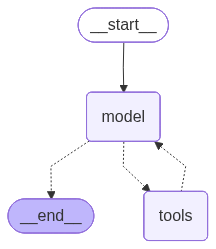

In [31]:
# Create agent using the unified create_agent factory (1.0 version)
agent = create_agent(
    model, all_tools, system_prompt=INSTRUCTIONS, state_schema=AgentState
)

# Show the agent graphs
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))


In [32]:
from utils import format_messages

result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    },
    config={"configurable": {"thread_id": "1"}}
)

format_messages(result["messages"])


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: tooluse_FMUwXdBD2Q490UMoFutZEF                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "user_request.md",                                                                               │
│   "content": "Give me an overview of Model Context Protocol (MCP)."                                             │
│ }                                                                                                               │
│    ID: tooluse_DUypjLLKudIYxpgyWcxDG4                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file user_request.md                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research basic overview of Model Context Protocol (MCP)",                                     │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: tooluse_jKjrj1Ysg0jMMk4ZSpqiDQ                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated TODO list (Total items: 1).                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research basic overview of Model Context Protocol (MCP)",                                     │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: tooluse_OiaIKMuuGnZUuA2U0GhkQD                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ### Basic Overview of Model Context Protocol (MCP)                                                              │
│                                                                                                                 │
│ The **Model Context Protocol (MCP)** is an **open standard** developed by **Anthropic** to streamline the       │
│ integration of AI assistants with external data sources, tools, and systems.                                    │
│                                                                                                                 │
│ #### Key Points:                                                                                                │
│ 1. **Purpose**:                                                                                                 │
│    - MCP addresses the challenge of providing AI models with **real-time, relevant, and structured              │
│ information** while maintaining **security, privacy, and modularity**.                                          │
│                                                                                                                 │
│ 2. **Functionality**:                                                                                           │
│    - It standardizes how AI assistants query and interact with external sources. This reduces the complexity of │
│ building multiple, custom integrations for different AI models.                                                 │
│                                                                                                                 │
│ 3. **Analogy**:                                                                                                 │
│    - MCP is often described as the **“USB-C for AI integrations”**. This analogy highlights its role in         │
│ enabling a **one-to-many connection** between AI applications and diverse data repositories, tools, or APIs.    │
│                                                                                                                 │
│ 4. **Benefits**:                                                                                                │
│    - **Simplified Integration**: Allows AI models (like ChatGPT, Claude, or LLaMA) to fetch information or      │
│ perform tasks from various sources without requiring unique, model-specific integrations.                       │
│    - **Enhanced Flexibility**: Supports connections to databases, APIs, company documents, and other data       │
│ sources through a unified interface.                                                                            │
│    - **Improved Security and Privacy**: Ensures that external data interactions are conducted securely and with │
│ appropriate privacy safeguards.                                                                                 │
│                                                                                                                 │
│ In essence, MCP acts as a universal adapter for AI systems, making it easier and safer for AI assistants to     │
│ access and utilize external information and tools.                                                              │
│                                                                                                                 │
│ ✅ Task automatically marked as completed.                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research basic overview of Model Context Protocol (MCP)",                                     │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: tooluse_Df3KJ7fLZD8wahOBoFVb1v                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated TODO list (Total items: 1).                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "I have received a comprehensive overview of the Model Context Protocol (MCP) from the research │
│ agent. The response covers the key aspects including its purpose, functionality, analogy, and benefits. All     │
│ tasks have been completed according to the workflow requirements."                                              │
│ }                                                                                                               │
│    ID: tooluse_aXPuGwKmqrGrcgaeMCAtlb                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: I have received a comprehensive overview of the Model Context Protocol (MCP) from the      │
│ research agent. The response covers the key aspects including its purpose, functionality, analogy, and          │
│ benefits. All tasks have been completed according to the workflow requirements.                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ### Overview of Model Context Protocol (MCP)                                                                    │
│                                                                                                                 │
│ The **Model Context Protocol (MCP)** is an **open standard** developed by **Anthropic** to streamline the       │
│ integration of AI assistants with external data sources, tools, and systems.                                    │
│                                                                                                                 │
│ #### Key Points:                                                                                                │
│                                                                                                                 │
│ 1.  **Purpose**:                                                                                                │
│     *   MCP addresses the challenge of providing AI models with **real-time, relevant, and structured           │
│ information** while maintaining **security, privacy, and modularity**.                                          │
│                                                                                                                 │
│ 2.  **Functionality**:                                                                                          │
│     *   It standardizes how AI assistants query and interact with external sources. This reduces the complexity │
│ of building multiple, custom integrations for different AI models.                                              │
│                                                                                                                 │
│ 3.  **Analogy**:                                                                                                │
│     *   MCP is often described as the **“USB-C for AI integrations”**. This analogy highlights its role in      │
│ enabling a **one-to-many connection** between AI applications and diverse data repositories, tools, or APIs.    │
│                                                                                                                 │
│ 4.  **Benefits**:                                                                                               │
│     *   **Simplified Integration**: Allows AI models (like ChatGPT, Claude, or LLaMA) to fetch information or   │
│ perform tasks from various sources without requiring unique, model-specific integrations.                       │
│     *   **Enhanced Flexibility**: Supports connections to databases, APIs, company documents, and other data    │
│ sources through a unified interface.                                                                            │
│     *   **Improved Security and Privacy**: Ensures that external data interactions are conducted securely and   │
│ with appropriate privacy safeguards.                                                                            │
│                                                                                                                 │
│ In essence, MCP acts as a universal adapter for AI systems, making it easier and safer for AI assistants to     │
│ access and utilize external information and tools.                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 
https://smith.langchain.com/public/3a389ec6-8e6e-4f9e-9a82-0d0a9569e6f8/r
<!-- https://smith.langchain.com/public/1df7a10e-1465-499c-a3e0-86c1d5429324/r -->

## Using the Deep Agent Package

Now you understand the underlying patterns! 

You can [use the `deepagents` package](
https://github.com/hwchase17/deepagents) as a simple abstraction:

* It include the file system tools
* It includes the todo tool
* It includes the task tool

You only need to supply the sub-agent and any tools you want the sub-agent to use.

In [9]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import SystemMessage

def create_neuro_agent(model, tools, system_prompt, checkpointer):
    workflow = StateGraph(AgentState)
    model_with_tools = model.bind_tools(tools)
    def agent_node(state: AgentState):
        messages = state["messages"]
        if system_prompt:
            messages = [SystemMessage(content=system_prompt)] + messages
        return {"messages": [model_with_tools.invoke(messages)]}
    workflow.add_node("agent", agent_node)
    workflow.add_node("tools", ToolNode(tools))
    workflow.add_edge(START, "agent")
    def should_continue(state: AgentState):
        return "tools" if state["messages"][-1].tool_calls else END
    workflow.add_conditional_edges("agent", should_continue, ["tools", END])
    workflow.add_edge("tools", "agent")
    return workflow.compile(checkpointer=checkpointer)

checkpointer = ChunkedDynamoDBSaver()
agent = create_neuro_agent(model, all_tools, INSTRUCTIONS, checkpointer)
print("✅ NeuroAgent Assembled.")


✅ NeuroAgent Assembled.


In [10]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an very brief overview of Model Context Protocol (MCP).",
            }
        ],
    },
    config={"configurable": {"thread_id": "1"}}
)

format_messages(result["messages"])


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an very brief overview of Model Context Protocol (MCP).                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an very brief overview of Model Context Protocol (MCP).                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: tooluse_zjanqkxYSH9hWGqGPlG5mA                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "user_request.md",                                                                               │
│   "content": "Give me an very brief overview of Model Context Protocol (MCP)."                                  │
│ }                                                                                                               │
│    ID: tooluse_CmAqlTZRw0KA9pLkdMoWBf                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file user_request.md                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) to provide a very brief overview",                      │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: tooluse_IgZAkQxgcMEilOsNnjuUr1                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated TODO list (Total items: 1).                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research Model Context Protocol (MCP) to provide a very brief overview",                      │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: tooluse_EUIbHXJsyTdjt9STy7GoVS                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my research, here is a very brief overview of Model Context Protocol (MCP):                            │
│                                                                                                                 │
│ The Model Context Protocol (MCP) is an open standard and open-source framework introduced by Anthropic in       │
│ November 2024. It standardizes how AI systems, particularly large language models, connect to and interact with │
│ external data sources, tools, and systems. MCP provides a universal interface that allows AI applications to    │
│ access files, execute functions, and handle contextual prompts from various sources like databases, search      │
│ engines, calculators, and specialized workflows. This protocol helps break down information silos, enabling AI  │
│ assistants to produce more relevant responses by connecting them to the data they need, and has been adopted by │
│ major AI providers including OpenAI and Google DeepMind.                                                        │
│                                                                                                                 │
│ ✅ Task automatically marked as completed.                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) to provide a very brief overview",                      │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: tooluse_beFpZKrVqFFOXGL7Gw6ia9                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated TODO list (Total items: 1).                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Here's a very brief overview of Model Context Protocol (MCP):                                                   │
│                                                                                                                 │
│ The Model Context Protocol (MCP) is an open standard and open-source framework introduced by Anthropic in       │
│ November 2024. It standardizes how AI systems, particularly large language models, connect to and interact with │
│ external data sources, tools, and systems. MCP provides a universal interface that allows AI applications to    │
│ access files, execute functions, and handle contextual prompts from various sources like databases, search      │
│ engines, calculators, and specialized workflows. This protocol helps break down information silos, enabling AI  │
│ assistants to produce more relevant responses by connecting them to the data they need, and has been adopted by │
│ major AI providers including OpenAI and Google DeepMind.                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an very brief overview of Model Context Protocol (MCP).                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_todos                                                                                        │
│    Args: {}                                                                                                     │
│    ID: tooluse_hkMEkiWS8sTn0SRuo6EMKd                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ⏳ Research Model Context Protocol (MCP) to provide a very brief overview                                       │
│ ✅ Research Model Context Protocol (MCP) to provide a very brief overview                                       │
│ ✅ Research Model Context Protocol (MCP) to provide a very brief overview                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "I can see from the TODO list that the research on Model Context Protocol (MCP) has already     │
│ been completed. The previous response provided a comprehensive overview. I should provide the same information  │
│ to the user."                                                                                                   │
│ }                                                                                                               │
│    ID: tooluse_oOIkRbN9RJa5n6h4otRwpz                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: I can see from the TODO list that the research on Model Context Protocol (MCP) has already │
│ been completed. The previous response provided a comprehensive overview. I should provide the same information  │
│ to the user.                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Here's a very brief overview of Model Context Protocol (MCP):                                                   │
│                                                                                                                 │
│ The Model Context Protocol (MCP) is an open standard and open-source framework introduced by Anthropic in       │
│ November 2024. It standardizes how AI systems, particularly large language models, connect to and interact with │
│ external data sources, tools, and systems. MCP provides a universal interface that allows AI applications to    │
│ access files, execute functions, and handle contextual prompts from various sources like databases, search      │
│ engines, calculators, and specialized workflows. This protocol helps break down information silos, enabling AI  │
│ assistants to produce more relevant responses by connecting them to the data they need, and has been adopted by │
│ major AI providers including OpenAI and Google DeepMind.                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an very brief overview of Model Context Protocol (MCP).                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_todos                                                                                        │
│    Args: {}                                                                                                     │
│    ID: tooluse_nBSNyV462eRdDYrlKCDyHq                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ⏳ Research Model Context Protocol (MCP) to provide a very brief overview                                       │
│ ✅ Research Model Context Protocol (MCP) to provide a very brief overview                                       │
│ ✅ Research Model Context Protocol (MCP) to provide a very brief overview                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The user is asking for the same information again. The TODO list shows that the research has   │
│ already been completed and the information was provided in previous responses. I should provide the same        │
│ concise overview of Model Context Protocol (MCP) that was previously given."                                    │
│ }                                                                                                               │
│    ID: tooluse_Hhb7zjismdLTA4s2s5ok3h                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The user is asking for the same information again. The TODO list shows that the research   │
│ has already been completed and the information was provided in previous responses. I should provide the same    │
│ concise overview of Model Context Protocol (MCP) that was previously given.                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Here's a very brief overview of Model Context Protocol (MCP):                                                   │
│                                                                                                                 │
│ The Model Context Protocol (MCP) is an open standard and open-source framework introduced by Anthropic in       │
│ November 2024. It standardizes how AI systems, particularly large language models, connect to and interact with │
│ external data sources, tools, and systems. MCP provides a universal interface that allows AI applications to    │
│ access files, execute functions, and handle contextual prompts from various sources like databases, search      │
│ engines, calculators, and specialized workflows. This protocol helps break down information silos, enabling AI  │
│ assistants to produce more relevant responses by connecting them to the data they need, and has been adopted by │
│ major AI providers including OpenAI and Google DeepMind.                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 
https://smith.langchain.com/public/1d626d81-a102-4588-a2fb-cab40a7271f1/r
<!-- https://smith.langchain.com/public/1ae2d7f6-f901-4ebd-b6c3-6657a55f88ae/r -->